In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,GlobalAveragePooling2D,BatchNormalization,Dropout
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau

In [3]:
x=pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
len(x)

21397

In [4]:
x.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [5]:
fractions=np.array([0.9,0.1])
x=x.sample(frac=1)
train_df,test_df=np.array_split(x,(fractions[:-1].cumsum()*len(x)).astype(int))

In [6]:
train_df.head()

,image_id,label
20640,847946899.jpg,3
298,1052881053.jpg,3
6565,2177297033.jpg,3
10770,2919064495.jpg,3
19912,715785641.jpg,0


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(train_df['image_id'], train_df['label'],
                                                    stratify=train_df['label'], 
                                                    test_size=0.3)

In [8]:
X_train=pd.DataFrame(X_train)
X_validate=pd.DataFrame(X_validate)
y_train=pd.DataFrame(y_train)
y_validate=pd.DataFrame(y_validate)

In [9]:
X_validate['label']=y_validate

In [10]:
X_validate.head()

,image_id,label
1904,1336010975.jpg,3
9093,2606913774.jpg,0
16469,3963604072.jpg,0
9811,2742945698.jpg,4
16291,3934961843.jpg,2


In [11]:
X_train['label']=y_train

In [12]:
X_train.head()

,image_id,label
12144,3174632328.jpg,3
10478,2869590198.jpg,3
12732,3278834779.jpg,3
1642,1287942179.jpg,3
12341,3211733449.jpg,2


In [13]:
y=pd.get_dummies(X_train['label'])
y
X_train=X_train.drop('label',axis=1)
train_df=pd.concat([X_train,y],axis=1)
train_df.columns=['image_id','Cassava Bacterial Blight (CBB)','Cassava Brown Streak Disease (CBSD)','Cassava Green Mottle (CGM)','Cassava Mosaic Disease (CMD)','Healthy']

train_df = train_df.astype({"image_id": object, "Cassava Bacterial Blight (CBB)": np.float32,"Cassava Brown Streak Disease (CBSD)": np.float32,"Cassava Green Mottle (CGM)": np.float32,"Cassava Mosaic Disease (CMD)": np.float32,"Healthy": np.float32})

In [14]:
y=pd.get_dummies(X_validate['label'])
y
X_validate=X_validate.drop('label',axis=1)
validate_df=pd.concat([X_validate,y],axis=1)
validate_df.columns=['image_id','Cassava Bacterial Blight (CBB)','Cassava Brown Streak Disease (CBSD)','Cassava Green Mottle (CGM)','Cassava Mosaic Disease (CMD)','Healthy']

validate_df = validate_df.astype({"image_id": object, "Cassava Bacterial Blight (CBB)": np.float32,"Cassava Brown Streak Disease (CBSD)": np.float32,"Cassava Green Mottle (CGM)": np.float32,"Cassava Mosaic Disease (CMD)": np.float32,"Healthy": np.float32})

In [15]:
y=pd.get_dummies(test_df['label'])
y
test_df=test_df.drop('label',axis=1)
test_dff=pd.concat([test_df,y],axis=1)
test_dff.columns=['image_id','Cassava Bacterial Blight (CBB)','Cassava Brown Streak Disease (CBSD)','Cassava Green Mottle (CGM)','Cassava Mosaic Disease (CMD)','Healthy']

test_dff = test_dff.astype({"image_id": object, "Cassava Bacterial Blight (CBB)": np.float32,"Cassava Brown Streak Disease (CBSD)": np.float32,"Cassava Green Mottle (CGM)": np.float32,"Cassava Mosaic Disease (CMD)": np.float32,"Healthy": np.float32})

In [16]:
print(len(train_df),len(validate_df),len(test_dff))

13479 5778 2140


In [17]:
labels = [
          'Cassava Bacterial Blight (CBB)',
          'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)',
          'Cassava Mosaic Disease (CMD)',
          'Healthy'
]

In [18]:
def data_leakage_check(df1,df2,col):
    
    df1_unique=set(df1[col])
    df2_unique=set(df2[col])
    
    same_images_in_both_groups=list(df1_unique.intersection(df2_unique))
    
    leakage=len(same_images_in_both_groups)!=0
    
    return leakage

In [19]:
print("Leakage between train and valid",data_leakage_check(train_df,validate_df,'image_id'))
print("Leakage between train and test",data_leakage_check(train_df,test_dff,'image_id'))
print("Leakage between test and valid",data_leakage_check(test_dff,validate_df,'image_id'))

Leakage between train and valid False
Leakage between train and test False
Leakage between test and valid False


In [20]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=32, target_w = 320, target_h = 320):
    
           
    print("getting train generator...") 
    
    image_generator = ImageDataGenerator(
        rotation_range=90,
        fill_mode='nearest',
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,1.5],
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            
            target_size=(target_w,target_h))
    
    return generator

In [21]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=200, batch_size=32, target_w = 320, target_h = 320):
    
    print("getting train and valid generators...")
    
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="image_id", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    
    batch = raw_train_generator.next()
    data_sample = batch[0]

    
    image_generator = ImageDataGenerator(
        
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    
    image_generator.fit(data_sample)

    
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=validate_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [22]:
IMAGE_DIR='../input/cassava-leaf-disease-classification/train_images'
train_generator=get_train_generator(train_df,IMAGE_DIR,"image_id",labels)
valid_generator,test_generator=get_test_and_valid_generator(validate_df,test_dff,train_df,IMAGE_DIR,"image_id",labels)

getting train generator...
Found 13479 validated image filenames.
getting train and valid generators...
Found 13479 validated image filenames.
Found 5778 validated image filenames.
Found 2140 validated image filenames.


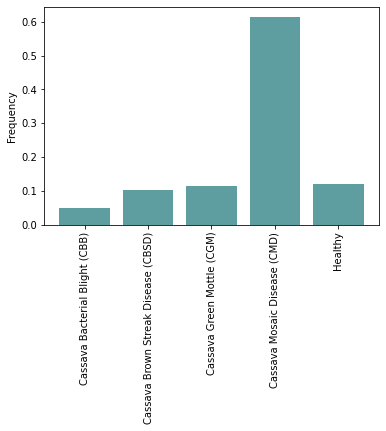

In [23]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0),color='cadetblue')
plt.ylabel("Frequency")
plt.show()

In [24]:
def compute_class_freqs(labels):
    
    N=len(labels)
    
    pos_f=np.sum(labels,axis=0)/N
    neg_f=1-np.sum(labels,axis=0)/N
    
    return pos_f,neg_f

In [25]:
f_pos,f_neg=compute_class_freqs(train_generator.labels)
f_pos

array([0.05037466, 0.10290081, 0.11291639, 0.6133244 , 0.12048372],
      dtype=float32)

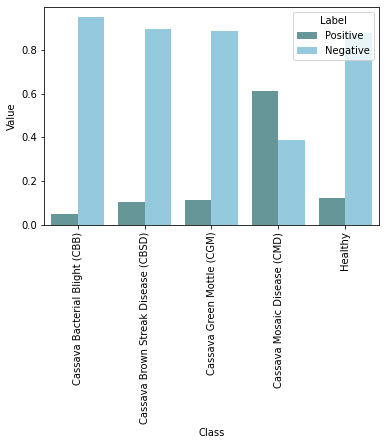

In [26]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": f_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(f_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data,palette=['#5f9ea0','#87CEEB'])

In [27]:
pos_weights=f_neg
neg_weights=f_pos
pos_c=f_pos*pos_weights
neg_c=f_neg*neg_weights

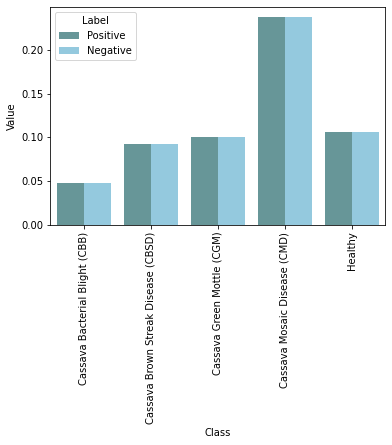

In [28]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_c})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_c)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data,palette=['#5f9ea0','#87CEEB']);

In [29]:

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        
        loss = 0.0
        
        for i in range(len(pos_weights)):
            
            loss += -(K.mean((pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon)) + (neg_weights[i] * (1-y_true[:,i]) * K.log(1-y_pred[:,i] + epsilon)),axis = 0)) #complete this line
        return loss
    
        
    return weighted_loss

In [32]:
def sensitivity(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [33]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [34]:
from tensorflow.keras.applications import DenseNet169
base_model = DenseNet169(weights='imagenet', include_top=False,input_shape=(320,320,3))


2022-09-26 04:31:44.735823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 04:31:44.830607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 04:31:44.831417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 04:31:44.833105: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

51888128/51877672 [==============================] - 0s 0us/step


In [35]:
import tensorflow as tf
import tensorflow_addons as tfa

In [36]:
import keras	
x=base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)

predictions=Dense(5,activation='sigmoid')(x)
import keras
model=Model(inputs=base_model.input,outputs=predictions)
optimiser=tf.keras.optimizers.Adam(lr=0.0001)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00001),loss=get_weighted_loss(pos_weights,neg_weights),metrics=['accuracy',specificity,sensitivity])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [37]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=int( np.ceil(len(train_df)/ 32) ),
                    validation_steps=int( np.ceil(len(validate_df)/ 32) ),
                              epochs = 90,
                              callbacks=[es]
                   )


2022-09-26 04:31:53.061720: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/90


2022-09-26 04:32:10.212634: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


422/422 [==============================] - 746s 2s/step - loss: 0.7726 - accuracy: 0.3563 - specificity: 0.5107 - sensitivity: 0.6726 - val_loss: 0.5101 - val_accuracy: 0.6772 - val_specificity: 0.6759 - val_sensitivity: 0.8693
Epoch 2/90
422/422 [==============================] - 600s 1s/step - loss: 0.5440 - accuracy: 0.6198 - specificity: 0.6966 - sensitivity: 0.8161 - val_loss: 0.4036 - val_accuracy: 0.7622 - val_specificity: 0.7905 - val_sensitivity: 0.8917
Epoch 3/90
422/422 [==============================] - 606s 1s/step - loss: 0.4512 - accuracy: 0.7082 - specificity: 0.7681 - sensitivity: 0.8558 - val_loss: 0.3536 - val_accuracy: 0.7890 - val_specificity: 0.8436 - val_sensitivity: 0.9001
Epoch 4/90
422/422 [==============================] - 610s 1s/step - loss: 0.3962 - accuracy: 0.7503 - specificity: 0.8125 - sensitivity: 0.8745 - val_loss: 0.3319 - val_accuracy: 0.7871 - val_specificity: 0.8482 - val_sensitivity: 0.8961
Epoch 5/90
422/422 [==============================] - 6

In [38]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [39]:
from shutil import copyfile

In [40]:
import random
tf.compat.v1.enable_eager_execution()
import cv2
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)

set_verbosity(INFO)


def get_mean_std_per_batch(image_path, df, H=256, W=256):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["image_id"].values):
        
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=256, W=256):
    
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

from tensorflow import GradientTape
def grad_cam(input_model, image, cls, layer_name, H=256, W=256):
    
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

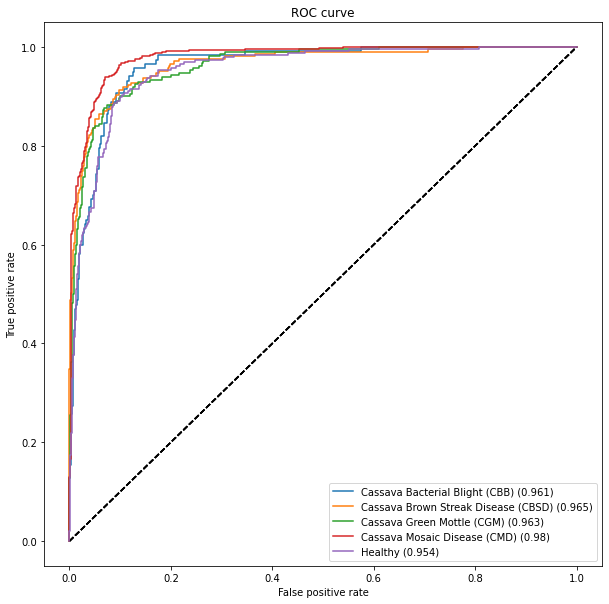

In [41]:
auc_rocs =get_roc_curve(labels, predicted_vals, test_generator)

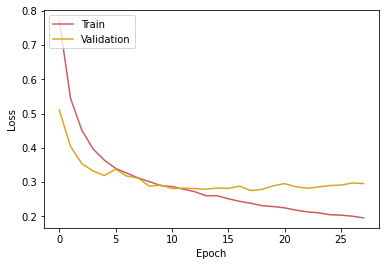

In [42]:
plt.plot(history.history['loss'],color='indianred')
plt.plot(history.history['val_loss'],color='goldenrod')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

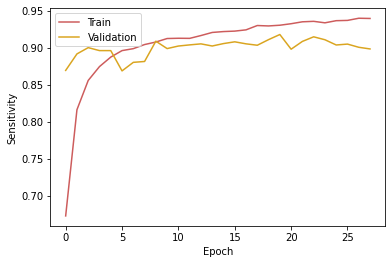

In [43]:
plt.plot(history.history['sensitivity'],color='indianred')
plt.plot(history.history['val_sensitivity'],color='goldenrod')
plt.ylabel('Sensitivity')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

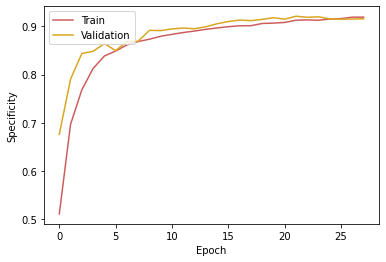

In [44]:
plt.plot(history.history['specificity'],color='indianred')
plt.plot(history.history['val_specificity'],color='goldenrod')
plt.ylabel('Specificity')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [45]:
sensitivity(test_generator.labels,predicted_vals)

<tf.Tensor: shape=(), dtype=float32, numpy=0.90654206>

In [46]:
specificity(test_generator.labels,predicted_vals)

<tf.Tensor: shape=(), dtype=float32, numpy=0.90899533>